In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt

### Import Data
Import and preprocess downloaded data, including dropping shots for which no land cover classification is available. Randomly permuting the shots guarantees that the test shots will not differ in distribution from the training shots. Note that the low-dimensional embedding of the rh profiles chosen here is a simple downsampling. Note that I tried less extreme downsamplings, without a noticeable difference in the accuracy of the resulting classifier.

In [2]:
shots = pd.concat(
    pd.read_csv("../data/" + g) for g in os.listdir("../data") if g.endswith(".csv")
)

In [3]:
shots = shots[shots["Class"] != "Not Classified"]
shots = shots.sample(frac=1).reset_index(drop=True)
n_shots, _ = shots.shape
print(n_shots, "total shots")
shots.head()

737847 total shots


,Unnamed: 0,Class,Group,beam,channel,lat_lowestmode,lon_lowestmode,elev_lowestmode,delta_time,rh,land_cover_data/landsat_water_persistence,land_cover_data/landsat_treecover,land_cover_data/region_class,land_cover_data/urban_proportion,land_cover_data/urban_focal_window_size,shot_number
0,564,Evergreen Forest,Forest,6,3,42.407600,-73.970320,177.65901,1.069808e+08,[-3.29 -1.57 -0.71 -0.07 0.52 1.16 1.98 3....,0,100.0,7,0,3,138400600300474342
1,5077,Deciduous Forest,Forest,11,5,43.269134,-77.281174,52.31818,8.630642e+07,[-6.81 -5.72 -4.9 -4.3 -3.81 -3.44 -3.14 -2....,0,98.0,7,0,3,101311100200280665
2,1299,Woody Wetlands,Wetlands,8,4,44.417889,-75.458568,69.87482,1.008601e+08,[-4.6 -3.78 -3.29 -2.99 -2.73 -2.54 -2.39 -2....,0,27.0,7,0,3,127420800300219043
3,2799,Deciduous Forest,Forest,8,4,44.152166,-74.844313,477.94254,8.494630e+07,[-8.61 -6.32 -3.7 -1.76 -0.56 0.26 1.16 2....,0,95.0,7,0,3,98870800200147124
4,52,Open Water,Water,3,1,43.436921,-78.929842,38.10626,7.950688e+07,[-1.86 -1.82 -1.74 -1.71 -1.63 -1.59 -1.52 -1....,100,0.0,0,0,3,89110300200114400


In [10]:
def str2np(rhstr):
    return np.fromstring(rhstr[1:-1], sep=' ')
    
rh = np.array([str2np(r) for r in shots["rh"]])
#idx = range(5, 96, 15)
idx = range(1, 100, 7)
rh = rh[:, idx]
rh.shape

(737847, 15)

In [5]:
classes = np.array(shots["Class"])
groups = np.array(shots["Group"])

### Split and Fit
Perform a simple train/test split and fit a NearestNeighbors object to the training data. Note that the order of the p-norm used in the embedding space does not seem to be important, and $p=\infty$ is the fastest to compute. Also note that the accuracy is not dramatically affected by reducing the size of the training set within roughly an order of magnitude.

In [26]:
split = int(n_shots * 0.7)
print(f"training on {split} shots, testing on {n_shots - split} shots")
class_train, classes_test = classes[:split], classes[split:]
group_train, group_test = groups[:split], groups[split:]
rh_train, rh_test = rh[:split], rh[split:]
neigh = NearestNeighbors(p=np.infty).fit(rh_train)

training on 516492 shots, testing on 221355 shots


### Hyperparameter Choice
The ```neigh``` object we've created can find the $k$ nearest neighbors of a query point. The majority label in this neighborhood can be used to classify the shot. Let's optimize the neighborhood size $k$.

In [7]:
def neigh_label(label_train, ind):
    """
    Given a set of labels for the training points and an array of nearest-neighbor 
    indices, return the labels of the nearest neighbors.
    """
    return label_train[ind.flatten()].reshape(ind.shape)

In [27]:
small_samp = 10000

for k in [1, 2, 5, 10, 20, 50, 100, 200, 500]:
    _, ind = neigh.kneighbors(rh_test[:small_samp], n_neighbors=k)
    neigh_group = neigh_label(group_train, ind)
    modes = pd.DataFrame(neigh_group).mode(axis=1)
    majority_group = modes.apply(lambda x: np.random.choice(x.dropna()), axis=1)  # random among equally common groups
    acc = balanced_accuracy_score(group_test[:small_samp], majority_group)
    print(f"k = {k} balanced accuracy of {acc}")

k = 1 balanced accuracy of 0.3183427036101298
k = 2 balanced accuracy of 0.32436507520429936
k = 5 balanced accuracy of 0.3467888441123592
k = 10 balanced accuracy of 0.35322891699359243
k = 20 balanced accuracy of 0.35434513103426774
k = 50 balanced accuracy of 0.3545079816961086
k = 100 balanced accuracy of 0.35460518125146523
k = 200 balanced accuracy of 0.35215442475263614
k = 500 balanced accuracy of 0.3480368729088178


The balanced accuracy is not high, but that's okay. Intuitively, the return profile from water should not be too different than the profile from a sports field. But $k=50$ is about the best we can do.

We could try setting the radius $r$ of each neighborhood rather than the number of neighbors $k$. This is time-consuming, due to the non-uniform density of the data, as illustrated by the plot below.

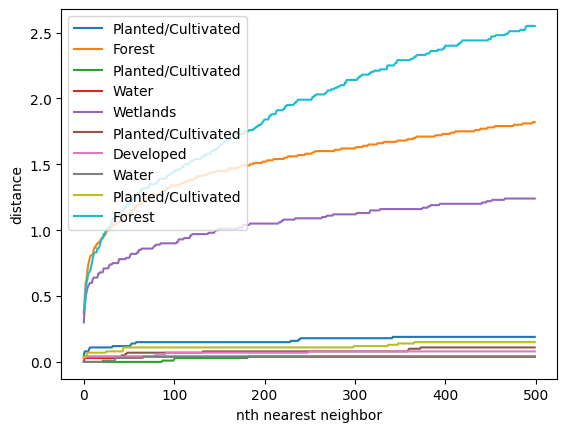

In [9]:
dist, _ = neigh.kneighbors(rh_test[:10], n_neighbors=500)
for i, d in enumerate(dist):
    plt.plot(d, label=group_test[i])
plt.xlabel("nth nearest neighbor"); plt.ylabel("distance")
plt.legend(); plt.show()

### 